In [1]:
import funs
import funs.model as model

import torch
import os

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision import transforms

import pandas as pd 

In [2]:
config = funs.load_yaml('./config.yaml')

funs.set_seed(config.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

aEp = 1
aRpm = 1400
aBearingType = "DeepGrooveBall"

device = cuda


In [3]:
model_name = f'FRFconv-TDS_{aEp}_rpm{aRpm}_{aBearingType}'
log_file = f'log_per_acc_{aEp}_rpm{aRpm}_{aBearingType}.txt'
cm_name = f'confusion_matrix_{aEp}_rpm{aRpm}_{aBearingType}.png'

In [4]:
data_root_dirs = os.path.join(config.dataset_root_uos)

# Cylindrical_dirs = funs.get_bearing_paths(data_root_dirs, 'CylindricalRoller', config.rpm, config.sampling_rate)
DepGroove_dirs = funs.get_bearing_paths(data_root_dirs, 'DeepGrooveBall', [aRpm], config.sampling_rate)
# Tapered_dirs = funs.get_bearing_paths(data_root_dirs, 'TaperedRoller', config.rpm, config.sampling_rate )

In [5]:
print("Making dataframes...")

# Cylindrical_df = funs.make_dataframe(config, Cylindrical_dirs)
DepGroove_df =funs.make_dataframe(config, DepGroove_dirs)
# Tapered_df = funs.make_dataframe(config, Tapered_dirs)

Making dataframes...


In [6]:
print("concat dataframes...")

# all_df = pd.concat([Cylindrical_df, DepGroove_df, Tapered_df], ignore_index=True)
all_df = DepGroove_df

concat dataframes...


In [7]:
train_df, val_df, test_df = funs.split_dataframe(all_df, 0.6, 0.2)

train_data, train_label = funs.build_from_dataframe(train_df, config.sample_size, config.overlap, False)
val_data, val_label = funs.build_from_dataframe(val_df, config.sample_size, config.overlap, False)
test_data, test_label = funs.build_from_dataframe(test_df, config.sample_size, config.overlap, False)

In [10]:
len(train_data[0])

2048

In [14]:
# np -> tensor transform
tf_data = transforms.Compose([funs.processing.NpToTensor(), funs.processing.ToSignal()])
tf_label = transforms.Compose([funs.processing.NpToTensor()])

In [15]:
train_dataset = funs.NumpyDataset(train_data, train_label, transform=tf_data, target_transform=tf_label)
val_dataset = funs.NumpyDataset(val_data, val_label, transform=tf_data, target_transform=tf_label)
test_dataset = funs.NumpyDataset(test_data, test_label, transform=tf_data, target_transform=tf_label)

train_loader = funs.get_dataloader(train_dataset, config.batch_size, True)
val_loader = funs.get_dataloader(val_dataset, config.batch_size, False)
test_loader = funs.get_dataloader(test_dataset, config.batch_size, False)

In [23]:
n_classes = all_df["label"].max() - all_df["label"].min() + 1
model = model.Mynet2(n_classes=n_classes).to(device)

In [24]:
optimizer = Adam(model.parameters(), lr = float(config.learning_rate))
loss = CrossEntropyLoss()

In [25]:
trainer = funs.Trainer(model, loss, optimizer, device, train_loader, val_loader)
train_loss, val_loss = trainer.train(aEp)
trainer.save(config.model_root, model_name)

model_path = f'{config.model_root}/{model_name}.pt'
trainer.model.load_state_dict(torch.load(model_path, weights_only=True))

fault_label_list, val_loss, predicted_label_list = trainer.test(test_loader) 


Starting Training... 
----------------------------------------
[EPOCH: 0] 
Train Loss: 2.13168
Train Acc: 0.20689
Validation Loss: 2.17008
----------------------------------------
[EPOCH: 1] 
Train Loss: 1.81642
Train Acc: 0.28743
Validation Loss: 1.61083
----------------------------------------

Starting Test... 
----------------------------------------
Test Loss: 1.59711


Class-wise Accuracy:
Class 0: 0.05645
Class 1: 0.00000
Class 2: 1.00000
Class 3: 0.03226
Class 4: 0.73387
Class 5: 0.00000
Class 6: 0.87903
Class 7: 0.00000
Class-wise accuracy logged to log_per_acc_1_rpm1400_DeepGrooveBall.txt


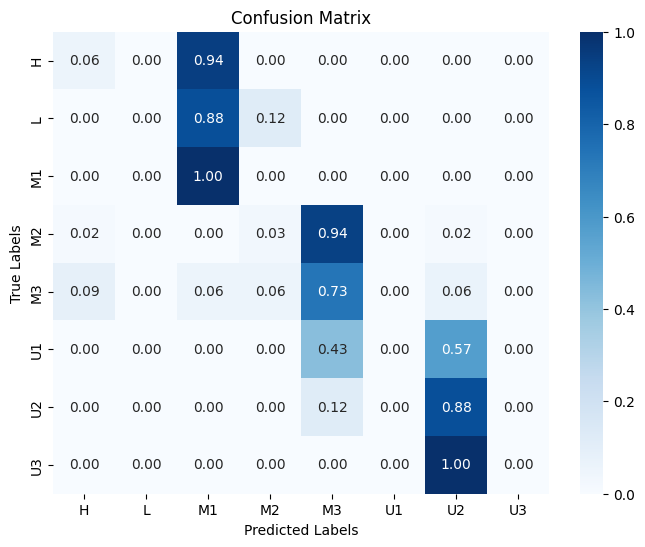

In [26]:
# acc per class logging
funs.log_class_acc(config.log_root, fault_label_list, predicted_label_list, f'{log_file}')

# confusion matrix plot
funs.plot_confusion_matrix(config.pic_root ,fault_label_list, predicted_label_list, cm_name)

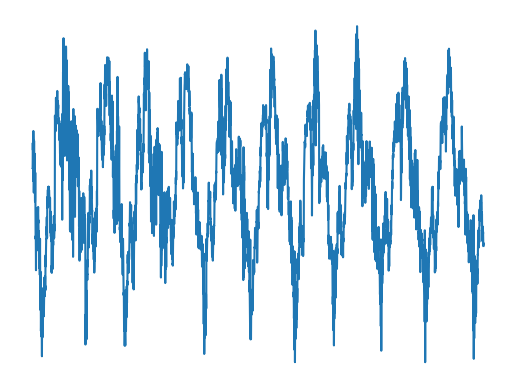

In [23]:
import numpy as np

machine = 'M2'

with open(f"data_st/{machine}/6204_1400_{machine}_2048_1.txt", 'r') as f:
    data = f.readlines()
body1 = np.array(data, np.float64)

with open(f"data_st/{machine}/6204_1400_{machine}_2048_2.txt", 'r') as f:
    data = f.readlines()
body2 = np.array(data, np.float64)

with open(f"data_st/{machine}/6204_1400_{machine}_2048_3.txt", 'r') as f:
    data = f.readlines()
body3 = np.array(data, np.float64)

data = np.concatenate([body1, body2, body3  ])

import matplotlib.pyplot as plt

plt.plot(data)
plt.axis('off')
plt.show()